In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -uq 'gdrive/My Drive/cats_flickr_splitted.zip' -d 'images/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/cats_flickr_splitted/train',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    'images/cats_flickr_splitted/validation',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

Using TensorFlow backend.


Found 29520 images belonging to 21 classes.
Found 10037 images belonging to 21 classes.


In [3]:
from collections import Counter

counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}

print(class_weights)

{0: 1.2599118942731278, 1: 1.1230366492146597, 2: 1.1818181818181819, 3: 1.261764705882353, 4: 1.653179190751445, 5: 1.43, 6: 1.3189853958493467, 7: 1.1966527196652719, 8: 1.3533123028391167, 9: 1.0, 10: 1.279642058165548, 11: 1.0778894472361809, 12: 1.0978886756238004, 13: 1.7421319796954315, 14: 1.1618144888287067, 15: 1.1409574468085106, 16: 1.035606517803259, 17: 1.1056701030927836, 18: 1.1673469387755102, 19: 1.0495412844036698, 20: 1.5815668202764976}


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

brain = Sequential()

brain.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(300, 300, 1)))
brain.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

brain.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
brain.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

brain.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
brain.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
brain.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
brain.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

brain.add(Flatten())
brain.add(Dense(4096, activation='relu'))
brain.add(Dropout(0.4))
brain.add(Dense(4096, activation='relu'))
brain.add(Dense(4096, activation='relu'))
brain.add(Dropout(0.4))
brain.add(Dense(21, activation='softmax'))

brain.compile(optimizer=SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
brain.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 73, 73, 96)        11712     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 384)       1327488   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 256)        

In [8]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               restore_best_weights=True)

output = brain.fit_generator(train_generator,
                             epochs=100,
                             validation_data=validation_generator,
                             class_weight=class_weights,
                             callbacks=[early_stopping])

plt.plot(output.history['loss'], label='Train loss')
plt.plot(output.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

plt.plot(output.history['acc'], label='Train accuracy')
plt.plot(output.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.show()

Epoch 1/100
 65/923 [=>............................] - ETA: 3:14 - loss: 1.0594 - acc: 0.7043

KeyboardInterrupt: ignored

TRUE CLASS:  Tonkinese
Tonkinese 75.432846
Burmese 20.511276
British Shorthair 2.874301
Siamese 0.8833221
Snowshoe 0.12444405
Chartreux 0.055617712
Birman 0.050179277
Russian Blue 0.03434728
Ragdoll 0.0152715


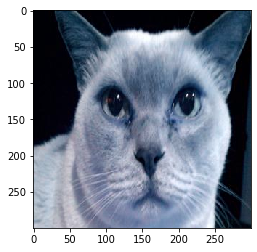

In [19]:
import cv2
import numpy as np
import os

classes = list(train_generator.class_indices.keys())
folder = np.random.choice(classes)
direc = 'images/cats_flickr_splitted/validation/'
filename = direc+folder+'/' + np.random.choice(os.listdir(direc+folder))
print('TRUE CLASS: ', folder)

image = cv2.imread(filename)
plt.imshow(image)
image = image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255

probs = brain.predict_proba(image.reshape(1, 300, 300, 1))*100

d = dict(zip(classes, probs[0]))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

i = 0
for c, p in d.items():
    if i == 9:
        break
    print(c, p)
    i += 1

Maine Coon 53.200268
Norwegian Forest 30.71501
Siberian 11.702093
Turkish Van 0.9070938
Snowshoe 0.818238
Turkish Angora 0.4233942
Abyssinian 0.41857368
Bengal 0.30222166
Russian Blue 0.30023655


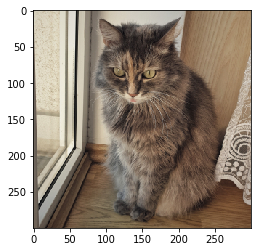

In [17]:
import cv2

classes = list(train_generator.class_indices.keys())

image = cv2.imread('sz.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_AREA)/255

probs = brain.predict_proba(image.reshape(1, 300, 300, 1))*100

d = dict(zip(classes, probs[0]))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}

i = 0
for c, p in d.items():
    if i == 9:
        break
    print(c, p)
    i += 1

In [0]:
brain.save('CatBreedifier_v2.h5')